# 뉴스기사 요약하기

## 1. 데이터 불러오기

In [1]:
import nltk
nltk.download('stopwords')

from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
74526,US deploys self-driving truck that can survive...,US state of Colorado has deployed a driverless...
42785,Singapore bars communications from terror atta...,Singapore's Parliament on Wednesday passed a l...
33909,Wearing glowing contacts during sleep may prev...,Caltech researchers have developed a glow-in-t...
65095,Every threat to peace in Middle East connected...,US Ambassador to the UN Nikki Haley on Wednesd...
58730,Wayne Rooney scores from 60 yards out to compl...,Ex-England captain Wayne Rooney scored from ne...
95712,"UP govt bans employee strikes at universities,...",The Yogi Adityanath-led Uttar Pradesh governme...
32962,"India, China to set up hotline between militar...",The militaries of India and China have reporte...
33317,Messi nets hat-trick as BarÃÂ§a win 7th La Li...,Five-time Ballon d'Or winner Lionel Messi nett...
46282,Marching under Russian flag banned at Olympics...,The International Olympic Committee has upheld...
23299,Foodpanda India may buy defunct food startup H...,Ola-owned online food ordering and delivery st...


In [4]:
data.shape

(98401, 2)

In [5]:
# 제목과 내용 길이 확인
print(len(data['headlines'][4000]), len(data['text'][4000]))

60 393


## 2. 데이터 전처리하기

### 2-1. 중복 샘플 지우기

In [6]:
# 중복 샘플 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# 중복된 내용 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 결측치 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 2-2. 정규화, 불용어 제거

In [9]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


NLTK 제공 불용어 리스트를 사용해서 불용어제거

In [10]:
# 불용어 사전 준비
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


제목과 내용 모두 불용어를 제거해본다. 나중에 성능이 별로면 기사는 불용어 제거하지 않고 테스트해본다.

In [12]:
# 정규화와 불용어 제거하기
clean_text = []
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))
    
clean_headlines = []
for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s))
    
data['text'] = clean_text
data['headlines'] = clean_headlines

print("text 전처리 후 결과: ", clean_text[:5])
print("\n headlines 전처리 후 결과: ", clean_headlines[:5])
print("\n 정규화, 불용어 제거 완료!!")

100%|██████████| 98360/98360 [01:47<00:00, 914.45it/s]

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
print("전체 샘플수 :", len(data))

전체 샘플수 : 98360


### 2-3. 훈련/테스트 셋 나누기 

문장 최대길이 구하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
텍스트의 표준편차 : 3.7993861876499637
제목의 최소 길이 : 1
제목의 최대 길이 : 13
제목의 평균 길이 : 7.136183407889386
제목의 표준편차 : 1.1624147471716224


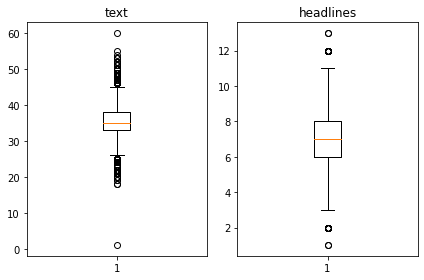

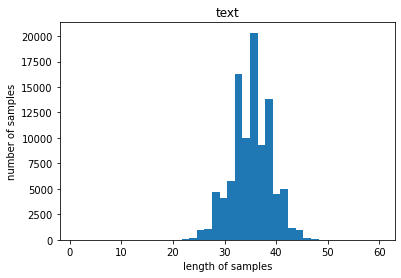

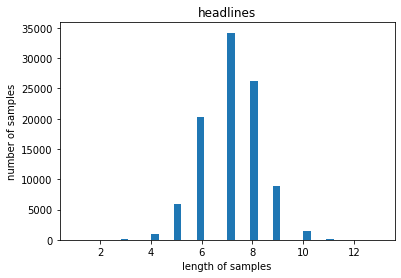

In [16]:
# 길이 분포 출력

# 각 문장을 단어로 잘라서 갯수를 센다.
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 표준편차 : {}'.format(np.std(text_len)))

print('제목의 최소 길이 : {}'.format(np.min(headlines_len)))
print('제목의 최대 길이 : {}'.format(np.max(headlines_len)))
print('제목의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('제목의 표준편차 : {}'.format(np.std(headlines_len)))


plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

최대 길이를 (평균 + 2 x 표준편차)로 한다.

In [17]:
text_max_len = np.mean(text_len) + 2 * np.std(text_len)
text_maxlen = int(text_max_len)
print('pad_sequences maxlen :', text_maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(text_len < text_max_len) / len(text_len)))

pad_sequences maxlen : 42
전체 문장의 0.9750305002033347%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
headlines_max_len = np.mean(headlines_len) + 2 * np.std(headlines_len)
headlines_maxlen = int(headlines_max_len)
print('pad_sequences maxlen :', headlines_maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(headlines_len < headlines_max_len) / len(headlines_len)))

pad_sequences maxlen : 9
전체 문장의 0.9826250508336722%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_maxlen)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_maxlen)]
print("전체 샘플수 :", (len(data)))

전체 샘플수 : 94367


### 2-4. 시작 토큰과 종료 토큰 추가

In [20]:
# 제목에 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken


넘파이 배열로 생성

In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 2-5. 훈련/테스트 셋 분리

In [22]:
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input, 
                                                                                                                                               decoder_input, 
                                                                                                                                               decoder_target, 
                                                                                                                                               test_size=0.2, 
                                                                                                                                               random_state=42)

print(encoder_input_train.shape, decoder_input_train.shape, decoder_target_train.shape)
print(encoder_input_test.shape, decoder_input_test.shape, decoder_target_test.shape)

(75493,) (75493,) (75493,)
(18874,) (18874,) (18874,)


### 2-6. 정수 인코딩

text 데이터를 정수인코딩한다.

In [23]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [24]:
src_tokenizer.word_index

{'said': 1,
 'india': 2,
 'added': 3,
 'year': 4,
 'us': 5,
 'also': 6,
 'government': 7,
 'first': 8,
 'police': 9,
 'people': 10,
 'two': 11,
 'indian': 12,
 'old': 13,
 'film': 14,
 'minister': 15,
 'president': 16,
 'one': 17,
 'crore': 18,
 'court': 19,
 'world': 20,
 'state': 21,
 'would': 22,
 'years': 23,
 'reportedly': 24,
 'new': 25,
 'time': 26,
 'delhi': 27,
 'last': 28,
 'reports': 29,
 'former': 30,
 'three': 31,
 'company': 32,
 'earlier': 33,
 'man': 34,
 'congress': 35,
 'like': 36,
 'country': 37,
 'bjp': 38,
 'based': 39,
 'claimed': 40,
 'trump': 41,
 'day': 42,
 'team': 43,
 'accused': 44,
 'chief': 45,
 'pakistan': 46,
 'actor': 47,
 'singh': 48,
 'allegedly': 49,
 'modi': 50,
 'according': 51,
 'women': 52,
 'pm': 53,
 'million': 54,
 'made': 55,
 'friday': 56,
 'tuesday': 57,
 'lakh': 58,
 'party': 59,
 'pradesh': 60,
 'wednesday': 61,
 'monday': 62,
 'comes': 63,
 'woman': 64,
 'called': 65,
 'around': 66,
 'video': 67,
 'asked': 68,
 'thursday': 69,
 'billion'

In [25]:
# src_tokenizer.word_counts.items()
threshold = 11
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 당어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq += value
    
    # 단어의 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67443
등장 빈도가 10번 이하인 희귀 단어의 수: 50427
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17016
단어 집합에서 희귀 단어의 비율: 74.76980561362929
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.9905765708757475


In [26]:
src_vocab = 17000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

print("단어 집합 생성완료!")

단어 집합 생성완료!


In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 변환됐는지 샘플 출력
print(encoder_input_train[:3])

[[5, 39, 234, 590, 1138, 71, 2651, 1850, 11846, 10, 2277, 8714, 11846, 812, 1850, 75, 3187, 9204, 5692, 1955, 2887, 1850, 234, 674, 116, 9572, 97, 4061, 1039, 590, 1594, 231], [1649, 3539, 741, 169, 1417, 13876, 4631, 1, 1251, 502, 13877, 194, 472, 4874, 2561, 1760, 318, 13876, 2813, 3219, 4523, 2362, 20, 305, 526, 47, 12579, 1993, 871, 1055, 9967, 2017, 13877, 875, 1761], [1574, 310, 991, 4002, 3409, 663, 388, 1033, 3188, 17, 4003, 1796, 6333, 254, 3946, 1917, 2218, 3409, 1, 882, 3409, 8, 3188, 8884, 529, 2675, 1796, 6334, 8885, 156, 220, 6334]]


headlines 데이터도 정수 인코딩 한다.

In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

print("단어 집합 생성완료!")

단어 집합 생성완료!


In [29]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29228
등장 빈도가 7번 이하인 희귀 단어의 수: 20762
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8466
단어 집합에서 희귀 단어의 비율: 71.03462433283153
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.695982192689285


In [30]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 18, 1051, 50, 2480, 2895], [1, 5615, 416, 144, 38, 6181, 556], [1, 326, 1221, 833, 4145, 2013], [1, 1862, 488, 1749, 380, 5141, 7869], [1, 2716, 83, 535, 541, 13, 734, 954]]
target
decoder  [[18, 1051, 50, 2480, 2895, 2], [5615, 416, 144, 38, 6181, 556, 2], [326, 1221, 833, 4145, 2013, 2], [1862, 488, 1749, 380, 5141, 7869, 2], [2716, 83, 535, 541, 13, 734, 954, 2]]


빈도수 낮은 단어들이 삭제 되었기 때문에 데이터가 비었는지 확인하고 삭제한다.

In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 3
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75490
훈련 레이블의 개수 : 75490
테스트 데이터의 개수 : 18874
테스트 레이블의 개수 : 18874


### 2-7 패딩하기

In [32]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_maxlen, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_maxlen, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_maxlen, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_maxlen, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_maxlen, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_maxlen, padding='post')

## 3. 어텐션 메커니즘 사용하기

### 3-1. 인코더 설계

In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_maxlen,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 3-2. 디코더 설계

In [34]:
from tensorflow.keras.layers import AdditiveAttention

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3-3 모델 훈련

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
295/295 [==============================] - 179s 574ms/step - loss: 5.8954 - val_loss: 5.5074
Epoch 2/50
295/295 [==============================] - 166s 564ms/step - loss: 5.3577 - val_loss: 5.1208
Epoch 3/50
295/295 [==============================] - 165s 560ms/step - loss: 5.0217 - val_loss: 4.8409
Epoch 4/50
295/295 [==============================] - 166s 563ms/step - loss: 4.7323 - val_loss: 4.6273
Epoch 5/50
295/295 [==============================] - 166s 562ms/step - loss: 4.4996 - val_loss: 4.4668
Epoch 6/50
295/295 [==============================] - 167s 565ms/step - loss: 4.3151 - val_loss: 4.3611
Epoch 7/50
295/295 [==============================] - 166s 564ms/step - loss: 4.1585 - val_loss: 4.2663
Epoch 8/50
295/295 [==============================] - 165s 559ms/step - loss: 4.0229 - val_loss: 4.2047
Epoch 9/50
295/295 [==============================] - 165s 561ms/step - loss: 3.9029 - val_loss: 4.1443
Epoch 10/50
295/295 [==============================] - 165s 559m

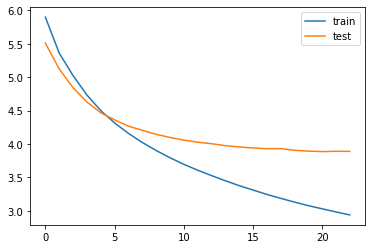

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 3-4. 인퍼런스 모델 구현

In [37]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [38]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, 
                                                    initial_state=[decoder_state_input_h, 
                                                                   decoder_state_input_c])

print('=3')

=3


In [39]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_maxlen, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_maxlen-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


### 3-5. 모델 테스트

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


## 4. 실제 결과와 요약문 비교하기

In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_maxlen)))
    print("\n")

원문 : former commander charge surgical strikes pakistan occupied kashmir last year lt gen hooda said strikes created fair amount panic pakistan side feared strikes adding army gained confidence ability carry complex cross border operations hooda said strikes increased morale soldiers 
실제 요약 : pakistan panic surgical strike ex commander 
예측 요약 :  surgical strikes surgical strikes strikes


원문 : accusing prime minister narendra modi selling dreams poor congress vice president rahul gandhi said pm modi give every gujarati house moon mocked pm modi saying bring moon earth gandhi said last day tour poll bound gujarat 
실제 요약 : pm modi give every gujarati house moon rahul 
예측 요약 :  pm modi tweets user rahul gandhi


원문 : three people including year old woman arrested thane allegedly cutting year old man genitals maharashtra police said man allegedly made unwanted advances towards woman thereafter hatched plot two others doctor said man critical condition adding private parts brain majorly inju

예측 요약 :  russia app lets users face id


원문 : nagpur set become country first city get fleet electric cabs pilot project see around electric cabs nagpur local body also provide charging stations across city centre currently runs faster adoption manufacturing electric vehicles scheme aims go completely electric 
실제 요약 : nagpur become st indian city electric cabs 
예측 요약 :  st indian railway stations get first time


원문 : supreme court sought jammu kashmir government reply plea moved kathua rape murder victim father shift trial chandigarh father counsel alleged atmosphere kathua conducive free fair trial trial eight accused began monday 
실제 요약 : sc seeks govt reply moving kathua case chandigarh 
예측 요약 :  sc orders kathua rape case kathua murder case


원문 : actor anil kapoor unveiled wax statue madame tussauds wax museum singapore unveiling truly thank making look good wax tweeted anil statue depicts character game show host oscar winning film millionaire reportedly first wax statue career

예측 요약 :  pakistan rejects pakistan terror attack india


원문 : family army jawan giri haryana sonepat area reportedly abducted liquor mafia allegedly opposing liquor vendor village giri currently posted jammu border said soldiers serving nation responsible safety family members administration needs answer 
실제 요약 : jawan family abducted liquor mafia haryana 
예측 요약 :  army jawan killed suspicion liquor




## 5. Summa를 이용해서 추출적 요약해보기

In [58]:
seq2text(encoder_input_test[i])

'family army jawan giri haryana sonepat area reportedly abducted liquor mafia allegedly opposing liquor vendor village giri currently posted jammu border said soldiers serving nation responsible safety family members administration needs answer '

In [48]:
from summa.summarizer import summarize

In [64]:
summarize(seq2text(encoder_input_test[i]))

''

In [59]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", summarize(seq2text(encoder_input_test[i])))
    print("\n")

원문 : former commander charge surgical strikes pakistan occupied kashmir last year lt gen hooda said strikes created fair amount panic pakistan side feared strikes adding army gained confidence ability carry complex cross border operations hooda said strikes increased morale soldiers 
실제 요약 : pakistan panic surgical strike ex commander 
예측 요약 : 


원문 : accusing prime minister narendra modi selling dreams poor congress vice president rahul gandhi said pm modi give every gujarati house moon mocked pm modi saying bring moon earth gandhi said last day tour poll bound gujarat 
실제 요약 : pm modi give every gujarati house moon rahul 
예측 요약 : 


원문 : three people including year old woman arrested thane allegedly cutting year old man genitals maharashtra police said man allegedly made unwanted advances towards woman thereafter hatched plot two others doctor said man critical condition adding private parts brain majorly injured 
실제 요약 : three including woman held cutting man genitals 
예측 요약 : 


원문